<a href="https://colab.research.google.com/github/SakVSF/Movie-Recommendation-Project/blob/main/CDS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/drive/MyDrive/tmdb_5000_credits.csv')

Data Cleaning and NLP text conversion (Count vector Bag of words)

In [ ]:
import numpy as np
import pandas as pd
import ast

# movies=pd.read_csv("tmdb_5000_movies.csv")
# credits=pd.read_csv("tmdb_5000_credits.csv")

movies=movies.merge(credits,on='title')

movies=movies[['movie_id','title','overview','keywords','cast','crew','genres']]
movies.dropna(inplace=True)

def convert(obj):
    L=[]
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

movies['genres']=movies['genres'].apply(convert)
movies['keywords']=movies['keywords'].apply(convert)

def convertcast(obj):
    L=[]
    counter=0
    for i in ast.literal_eval(obj):
        if counter<3:
            L.append(i['name'])
            counter+=1
        else:
            break
    return L

movies['cast']=movies['cast'].apply(convertcast)

def convertcrew(obj):
    L=[]
    for i in ast.literal_eval(obj):
        if i['job']=='Director':
            L.append(i['name'])
            break
    return L

movies['crew']= movies['crew'].apply(convertcrew)
movies['crew']

def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

def collapse(L):
  L1 = []
  for i in L:
      L1.append(i.replace(" ",""))
  return L1

movies['overview'] = movies['overview'].apply(lambda x:x.split())
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

new = movies.drop(columns=['overview','genres','keywords','cast','crew'])
new['tags'] = new['tags'].apply(lambda x: " ".join(x))
new['tags'] = new['tags'].apply(lambda x: x.lower())

new_df=new[['movie_id','title','tags']]

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()

cv = CountVectorizer(max_features=5000,stop_words='english')

def stem(text):
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y) #changing list to string

new_df['tags']=new_df['tags'].apply(stem)

vectors=cv.fit_transform(new_df['tags']).toarray()

X = new_df['tags']

one_hot_vectors = vectors

# X_tsne = TSNE(n_components=3, perplexity=60, random_state=42).fit_transform(vectors[:200])

# # Visualize the data using a scatter plot
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
# plt.show()

Data Visualization for the Tags column

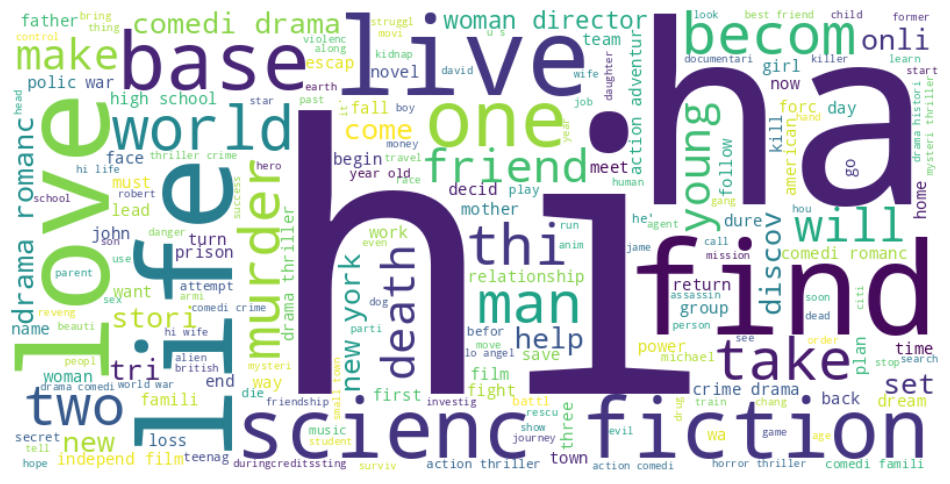

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all tags
all_tags = " ".join(new_df['tags'])

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(all_tags)

# Display the wordcloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


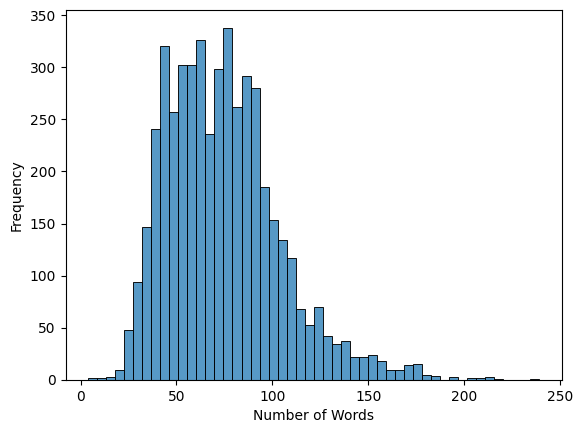

In [ ]:
#create a histogram of the word counts to see the distribution of word frequencies 
import seaborn as sns

# calculate the word counts
word_counts = X.str.split().apply(len)

# create the histogram
sns.histplot(word_counts, bins=50)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


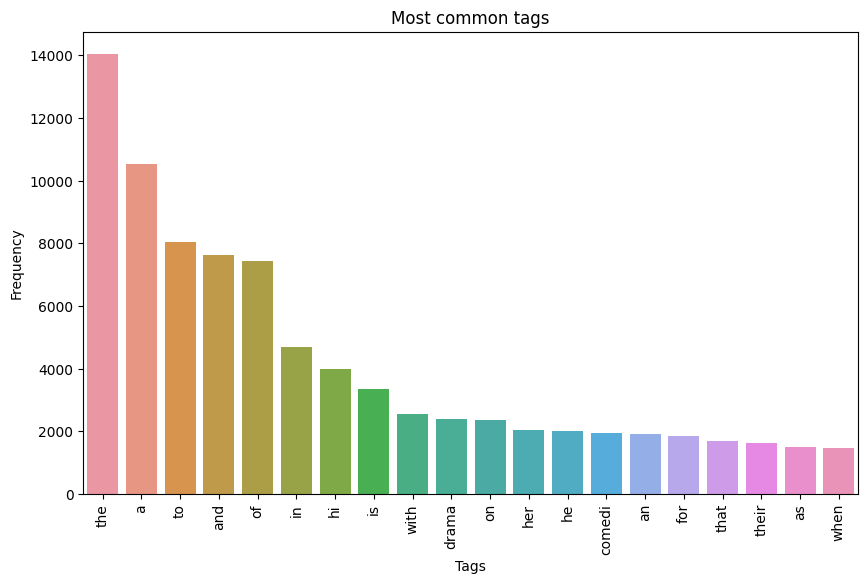

In [ ]:
import seaborn as sns

# Get the frequency of each tag
tag_freq = pd.Series(" ".join(new_df['tags']).split()).value_counts()

# Create a bar chart of the top 20 tags
plt.figure(figsize=(10,6))
sns.barplot(x=tag_freq[:20].index, y=tag_freq[:20].values)
plt.xticks(rotation=90)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Most common tags')
plt.show()


<Axes: xlabel='tags', ylabel='Density'>

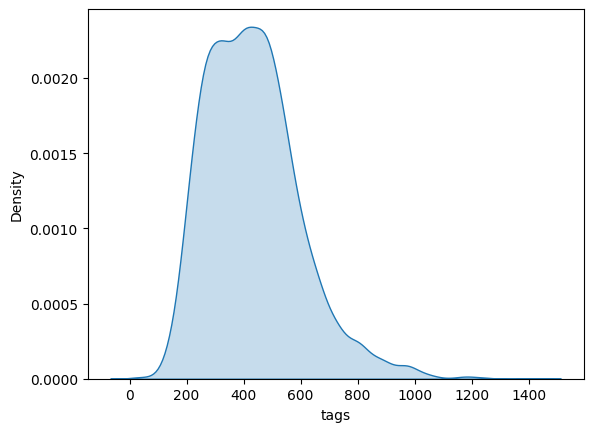

In [ ]:
import seaborn as sns

sns.kdeplot(new_df['tags'].str.len(), fill=True)


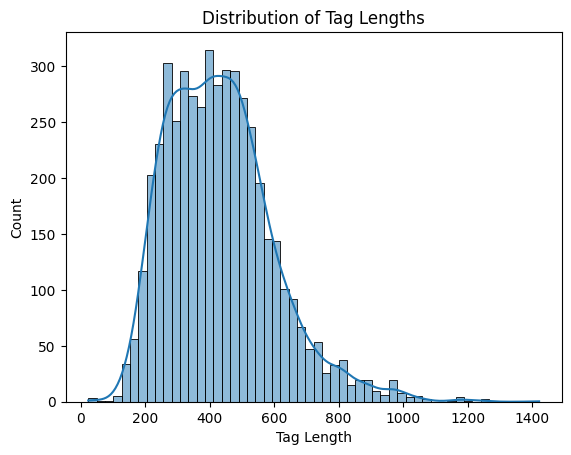

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of tag lengths
tag_lens = new_df['tags'].apply(len)
sns.histplot(tag_lens, kde=True)
plt.title('Distribution of Tag Lengths')
plt.xlabel('Tag Length')
plt.show()

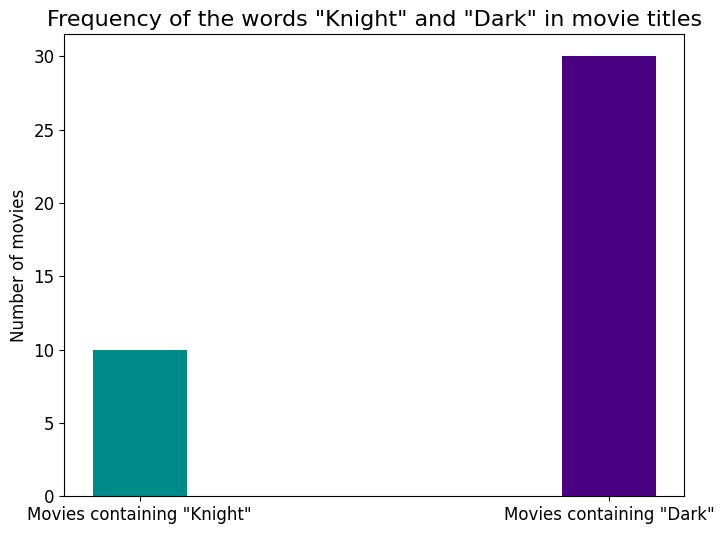

In [ ]:
# Filter for movies containing "Knight" and "Dark"
knight_movies = new_df[new_df['title'].str.contains('Knight')]
dark_movies = new_df[new_df['title'].str.contains('Dark')]

# Count the number of movies containing each word
count_knight = len(knight_movies['title'])
count_dark = len(dark_movies['title'])

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Movies containing "Knight"', 'Movies containing "Dark"'], [count_knight, count_dark], color=['darkcyan', 'indigo'], width =0.2)
plt.title('Frequency of the words "Knight" and "Dark" in movie titles', fontsize=16)
plt.ylabel('Number of movies', fontsize=12)
plt.tick_params(labelsize=12)
plt.show()




In [ ]:
new_df.head(5)

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,a cryptic messag from bond’ past send him on a...
3,49026,The Dark Knight Rises,follow the death of district attorney harvey d...
4,49529,John Carter,"john carter is a war-weary, former militari ca..."


One-Hot Vectors

In [ ]:
# # Run t-SNE on the TF-IDF matrix
# X_tsne = TSNE(n_components=2, random_state=42).fit_transform(one_hot_vectors)
# # Create a new DataFrame with the t-SNE embeddings and the movie titles
# tsne_df = pd.DataFrame({'tsne_x': X_tsne[:, 0], 'tsne_y': X_tsne[:, 1], 'title': new_df['title']})
# # Create an interactive scatter plot using Plotly
# fig = px.scatter(tsne_df, x='tsne_x', y='tsne_y', hover_data=['title'])
# # Customize the plot layout
# fig.update_layout(title='t-SNE One Hot Embeddings', xaxis_title='t-SNE Component 1', yaxis_title='t-SNE Component 2', width=800, height=800)
# # Display the plot
# fig.show()

In [ ]:
import plotly.graph_objs as go
# Convert the text-based dataframe to a TF-IDF matrix
# Run t-SNE on the TF-IDF matrix
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(one_hot_vectors)
# Create a new DataFrame with the t-SNE embeddings and the movie titles
tsne_df = pd.DataFrame({'tsne_x': X_tsne[:, 0], 'tsne_y': X_tsne[:, 1], 'title': new_df['title']})
# Create a scatter plot trace with movie titles as hover text
trace = go.Scatter(x=tsne_df['tsne_x'], y=tsne_df['tsne_y'], mode='markers', text=tsne_df['title'], hoverinfo='text')
# Create a text trace to display the movie titles next to the data points
text_trace = go.Scatter(x=tsne_df['tsne_x'], y=tsne_df['tsne_y'], mode='text', text=tsne_df['title'], textposition='middle right', hoverinfo='none')
# Create a Plotly figure with both traces
fig = go.Figure(data=[trace, text_trace])
# Customize the plot layout
fig.update_layout(title='t-SNE Embeddings for TF-IDF', xaxis_title='t-SNE Component 1', yaxis_title='t-SNE Component 2', width=800, height=800)
# Display the plot
fig.show()

TF-IDF

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
import plotly.graph_objs as go

from sklearn.feature_extraction.text import TfidfVectorizer

# Define the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Convert the text-based dataframe to a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(X).toarray()

# Print the TF-IDF matrix shape
print(X_tfidf.shape)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt




(4806, 5000)


In [ ]:
# Run t-SNE on the TF-IDF matrix
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_tfidf)
# Create a new DataFrame with the t-SNE embeddings and the movie titles
tsne_df = pd.DataFrame({'tsne_x': X_tsne[:, 0], 'tsne_y': X_tsne[:, 1], 'title': new_df['title']})
# Create an interactive scatter plot using Plotly
fig = px.scatter(tsne_df, x='tsne_x', y='tsne_y', hover_data=['title'])
# Customize the plot layout
fig.update_layout(title='t-SNE TF-IDF', xaxis_title='t-SNE Component 1', yaxis_title='t-SNE Component 2', width=800, height=800)
# Display the plot
fig.show()

In [ ]:
import plotly.graph_objs as go
# Convert the text-based dataframe to a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(new_df['tags']).toarray()
# Run t-SNE on the TF-IDF matrix
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_tfidf)
# Create a new DataFrame with the t-SNE embeddings and the movie titles
tsne_df = pd.DataFrame({'tsne_x': X_tsne[:, 0], 'tsne_y': X_tsne[:, 1], 'title': new_df['title']})
# Create a scatter plot trace with movie titles as hover text
trace = go.Scatter(x=tsne_df['tsne_x'], y=tsne_df['tsne_y'], mode='markers', text=tsne_df['title'], hoverinfo='text')
# Create a text trace to display the movie titles next to the data points
text_trace = go.Scatter(x=tsne_df['tsne_x'], y=tsne_df['tsne_y'], mode='text', text=tsne_df['title'], textposition='middle right', hoverinfo='none')
# Create a Plotly figure with both traces
fig = go.Figure(data=[trace, text_trace])
# Customize the plot layout
fig.update_layout(title='t-SNE Embeddings for TF-IDF', xaxis_title='t-SNE Component 1', yaxis_title='t-SNE Component 2', width=800, height=800)
# Display the plot
fig.show()

Auto encoder (One-hot)

In [ ]:
#AUTOENCODER
# Define the input shape and size of the encoded representation
input_shape = (one_hot_vectors.shape[1],)
encoded_size = 100

# Define the autoencoder architecture
inputs = keras.Input(shape=input_shape)
encoded = layers.Dense(encoded_size, activation='relu')(inputs)
decoded = layers.Dense(input_shape[0], activation='sigmoid')(encoded)
autoencoder = keras.Model(inputs, decoded)

# Compile the autoencoder and train it on the one hot vectors
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(one_hot_vectors, one_hot_vectors, epochs=3)

# Obtain the compressed representation of the one-hot vectos 
encoder = keras.Model(inputs, encoded)
compressed = encoder.predict(one_hot_vectors)

print(one_hot_vectors.shape)
print(compressed.shape)



Epoch 1/3
151/151 [==============================] - 5s 26ms/step - loss: 0.0452
Epoch 2/3
151/151 [==============================] - 3s 20ms/step - loss: 0.0111
Epoch 3/3
151/151 [==============================] - 1s 3ms/step
(4806, 5000)
(4806, 100)


In [ ]:
# Run t-SNE on the TF-IDF matrix
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(compressed)
# Create a new DataFrame with the t-SNE embeddings and the movie titles
tsne_df = pd.DataFrame({'tsne_x': X_tsne[:, 0], 'tsne_y': X_tsne[:, 1], 'title': new_df['title']})
# Create an interactive scatter plot using Plotly
fig = px.scatter(tsne_df, x='tsne_x', y='tsne_y', hover_data=['title'])
# Customize the plot layout
fig.update_layout(title='t-SNE AutoEncoder Embeddings', xaxis_title='t-SNE Component 1', yaxis_title='t-SNE Component 2', width=800, height=800)
# Display the plot
fig.show()

Word2Vec

In [ ]:
import gensim
from gensim.models import Word2Vec

# Define the sentences for training the Word2Vec model
#sentences = [text.split() for text in X]

sentences = X

#print(sentences)

# Train the Word2Vec model
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

# Convert each sentence in the dataframe to a Word2Vec vector
X_word2vec = []
for sentence in sentences:
    sentence_vec = []
    for word in sentence:
        if word in model.wv.key_to_index:
            sentence_vec.append(model.wv.get_vector(word))
    X_word2vec.append(sentence_vec)


max_sentence_length = max(len(sentence_vec) for sentence_vec in X_word2vec)
arrays = np.zeros((len(X_word2vec), max_sentence_length, 100))
for i, sentence_vec in enumerate(X_word2vec):
    for j, word_vec in enumerate(sentence_vec):
        arrays[i,j] = word_vec

arrays = arrays.reshape(len(arrays), -1)

X_word2vec = arrays

# Print the Word2Vec representation of the first sentence in the dataframe
print(X_word2vec[0])




num_samples = int(0.01 * X_word2vec.shape[0])
indices = np.random.choice(X_word2vec.shape[0], num_samples, replace=False)
selected_samples = X_word2vec[indices]



[-0.24112287  0.31405818 -0.0165069  ...  0.          0.
  0.        ]


In [ ]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_word2vec)
# Create a new DataFrame with the t-SNE embeddings and the movie titles
tsne_df = pd.DataFrame({'tsne_x': X_tsne[:, 0], 'tsne_y': X_tsne[:, 1], 'title': new_df['title']})
# Create an interactive scatter plot using Plotly
fig = px.scatter(tsne_df, x='tsne_x', y='tsne_y', hover_data=['title'])
# Customize the plot layout
fig.update_layout(title='t-SNE Word2Vec Embeddings', xaxis_title='t-SNE Component 1', yaxis_title='t-SNE Component 2', width=800, height=800)
# Display the plot
fig.show()

In [ ]:
selected_samples.shape

(48, 142200)

Doc2vec

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
from gensim import utils
from random import shuffle
from bs4 import BeautifulSoup
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, 'html.parser').text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

X = X.apply(clean_text)

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm

def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

all_data = label_sentences(X, 'all_data')

model_dbow = Doc2Vec(dm=0, vector_size=5000, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(1):
    model_dbow.train(corpus_iterable=all_data, total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-22-66fd1990be72>:13: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

100%|██████████| 4806/4806 [00:00<00:00, 1624452.01it/s]


In [ ]:
vectors_dbow = get_vectors(model_dbow, len(all_data), 5000, "all_data")
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(vectors_dbow)
# Create a new DataFrame with the t-SNE embeddings and the movie titles
tsne_df = pd.DataFrame({'tsne_x': X_tsne[:, 0], 'tsne_y': X_tsne[:, 1], 'title': new_df['title']})
# Create an interactive scatter plot using Plotly
fig = px.scatter(tsne_df, x='tsne_x', y='tsne_y', hover_data=['title'])
# Customize the plot layout
fig.update_layout(title='t-SNE Embeddings for Movie Tags', xaxis_title='t-SNE Component 1', yaxis_title='t-SNE Component 2', width=800, height=800)
# Display the plot
fig.show()

<ipython-input-22-66fd1990be72>:46: DeprecationWarning:

Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).



Cosine similarity

In [ ]:
##Different Models
from sklearn.metrics.pairwise import cosine_similarity

all_preprocessed_data = [X_word2vec ,  X_tfidf, one_hot_vectors, vectors_dbow, compressed ]
preprocess_type = ["Word2Vec", "TF-IDF",  "Count-Vector(one-hot)", "Doc2Vec", "Auto-encoders"]

recommended_movies_from_models = []

def recommend(movie):
    new_list = []
    index_movie = new_df[new_df['title'] == movie].index[0] #figure out the index of this movie 
    distances = cosine_similar_model[index_movie] #pass in the index to the model
    movielist=sorted(list(enumerate(distances)),reverse=True,key = lambda x: x[1])[1:6]

    # then the model returns the closest vectors to the input reverse done to get in descending order
    for i in movielist:
        movie = new_df.iloc[i[0]].title
        new_list.append(movie)
        #print(movie)
    return new_list

for data in all_preprocessed_data:
    cosine_similar_model=cosine_similarity(data)
    recommended_movies_from_models.append(recommend('Hulk')) 

#Recommend for Hulk
recommend('Hulk')
#print(recommended_movies_from_models)

for i in range (len(preprocess_type)):
  print(preprocess_type[i] ,":", recommended_movies_from_models[i])

Word2Vec : ['Transcendence', 'The Fault in Our Stars', 'The Apparition', 'The Cave', 'Ordinary People']
TF-IDF : ['The Incredible Hulk', 'The Island of Dr. Moreau', 'Transformers: Age of Extinction', 'X2', 'Species']
Count-Vector(one-hot) : ['The Incredible Hulk', 'Transformers: Age of Extinction', 'Ant-Man', 'X2', 'Shin Godzilla']
Doc2Vec : ['Robin Hood: Prince of Thieves', 'Eat Pray Love', 'Inglourious Basterds', 'The SpongeBob Movie: Sponge Out of Water', 'The Mask of Zorro']
Auto-encoders : ['Assassins', 'Valkyrie', 'Bound by Honor', 'The Prince of Egypt', 'The Andromeda Strain']


KNN

In [ ]:
# Fit the Nearest Neighbors model
import numpy as np
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import KMeans

all_preprocessed_data = [X_word2vec ,  X_tfidf, one_hot_vectors, vectors_dbow, compressed ]
preprocess_type = ["Word2Vec", "TF-IDF",  "Count-Vector(one-hot)", "Doc2Vec", "Auto-encoders"]

recommended_movies_from_models = []



model = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')


model.fit(data) #Bag of words

#model.fit(data) # DoC2Vec

# Define the recommend function using the KNN model
def recommend(movie):
    #figure out the index of this movie
    new_list = []

    index_movie = new_df[new_df['title'] == movie].index[0] 
    #find out the distance and index of neighbors using the KNN model, 
    distances, indices = model.kneighbors([data[index_movie]])
    # Print the recommended movies
    for i in indices[0][1:]:
        movie = new_df.iloc[i].title
        new_list.append(movie)
        #print(movie)
    return new_list

for data in all_preprocessed_data:
    model.fit(data)
    recommended_movies_from_models.append(recommend('Hulk')) #recommend for hulk

for i in range (len(preprocess_type)):
  print(preprocess_type[i] ,":", recommended_movies_from_models[i])



Word2Vec : ['Batman', 'Harrison Montgomery', 'The Helix... Loaded', 'Sardaarji', 'The Hadza:  Last of the First']
TF-IDF : ['Batman', 'Batman & Robin', 'Batman Returns', 'The Dark Knight Rises', 'Batman Begins']
Count-Vector(one-hot) : ['Batman', "Amidst the Devil's Wings", 'The Helix... Loaded', 'Batman & Robin', 'Harrison Montgomery']
Doc2Vec : ['Meet the Deedles', 'The Intern', 'Magnolia', "We're the Millers", "A Knight's Tale"]
Auto-encoders : ['Batman', 'Batman', 'Below Zero', 'The Chronicles of Riddick', 'Beetlejuice']


(['Batman', 'Batman', 'Below Zero', 'The Chronicles of Riddick', 'Beetlejuice'], array([[1362, 1363, 1364, 4317,  223, 2536]]))


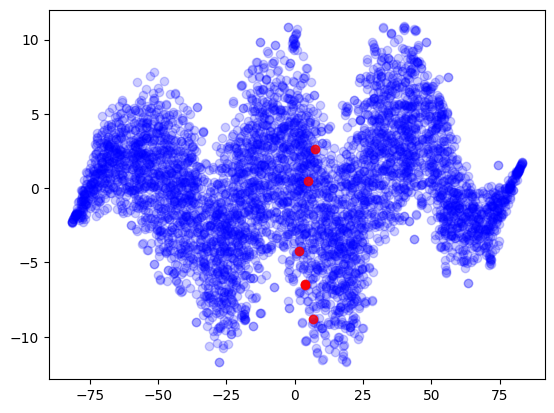

In [ ]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
data = compressed

model.fit(data)

def recommend(movie):
    #figure out the index of this movie
    new_list = []

    index_movie = new_df[new_df['title'] == movie].index[0] 
    #find out the distance and index of neighbors using the KNN model, 
    distances, indices = model.kneighbors([data[index_movie]])
    # Print the recommended movies
    for i in indices[0][1:]:
        movie = new_df.iloc[i].title
        new_list.append(movie)
        #print(movie)
    return new_list, indices

print(recommend('Hulk'))

index_list = recommend('Hulk')[1]
word_embeds = data[index_list] [0]

from sklearn.manifold import TSNE

# Define the t-SNE model
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(data)
indices_to_highlight = index_list

# Plot the scatterplot
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', alpha=0.2)
plt.scatter(X_tsne[indices_to_highlight, 0], X_tsne[indices_to_highlight, 1], c='red', alpha=0.8)
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
data = one_hot_vectors


cosine_similar_model=cosine_similarity(data)

def recommend(movie):
    new_list = []
    index_movie = new_df[new_df['title'] == movie].index[0] #figure out the index of this movie 
    distances = cosine_similar_model[index_movie] #pass in the index to the model
    movielist=sorted(list(enumerate(distances)),reverse=True,key = lambda x: x[1])[1:6]
    # then the model returns the closest vectors to the input reverse done to get in descending order
    for i in movielist:
        movie = new_df.iloc[i[0]].title
        new_list.append(movie)
        #print(movie)
    return new_list, movielist


print(recommend('Hulk'))

index_list = recommend('Hulk')[1]


word_embeds = []
for i in index_list:
    word_embeds.append(i[0])

from sklearn.manifold import TSNE

# Define the t-SNE model
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(data)
indices_to_highlight = word_embeds

# Plot the scatterplot
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', alpha=0.2)
plt.scatter(X_tsne[indices_to_highlight, 0], X_tsne[indices_to_highlight, 1], c='red', alpha=0.8)
plt.show()


In [ ]:
new_index_list = []
for i in index_list:
    new_index_list.append(i[0])
print(new_index_list)

[1363, 119, 842, 3, 428]
